In [1]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import sys
import os
import json
import pandas as pd
import fnmatch
import base64
import requests
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
model_checkpoint2 = "sberbank-ai/ruRoberta-large"
path_to_model = "./doc-classification/"

labels = ['Практика коммерческой логистики',
          'Практика недропользования и экологии',
          'Практика поддержки региональных, розничных продаж и клиентского сервиса',
          'Практика правового сопровождения закупок МТР и услуг общего профиля',
          'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом',
          'Практика правового сопровождения операционной деятельности БРД',
          'Практика правового сопровождения переработки и инфраструктуры',
          'Практика правовой поддержки брендов',
          'Практика правовой поддержки использования и коммерциализации ИС',
          'Практика правовой поддержки создания и приобретения ИС',
          'Практика промышленной безопасности и охраны труда',
          'Практика финансового и конкурентного права',
          'Практика экспорта, оптовых продаж и сбыта бизнес-единиц (БЕ)']

model = TFAutoModelForSequenceClassification.from_pretrained(
    str(path_to_model), num_labels=len(labels), from_pt=False
)
tokenizer = AutoTokenizer.from_pretrained(str(model_checkpoint2))

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ./doc-classification/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [3]:
arrOfAllDocs = []

for root, dir_names, filenames in os.walk('Документы\Входящие по практикам'):
    if len(root.split('\\')) == 2: continue
    flag = False
    for i in root.split('\\'):
        if str(i).startswith('Исключена'):
            flag = True
            break
    if flag: continue
    for filename in fnmatch.filter(filenames, '*.docx'):
        arrOfAllDocs.append(os.path.join(root, filename))
    for filename in fnmatch.filter(filenames, '*.doc'):
        arrOfAllDocs.append(os.path.join(root, filename))


In [7]:
def get_json_from_parser(path, filename):
    result = ""
    headers = {
        'Content-type': 'application/json',
        'Accept': 'application/json; text/plain'
    }
    try:
        doc = open(path, 'rb')
        encoded_string = base64.b64encode(doc.read())
        encoded_string = str(encoded_string)[2:-1]
    except Exception as e:
        print(f"\nОшибка в файле {path}")
        print(f"при конвертации в base64, исключение = {e}")
        print("=" * 100)
        return
    is_doc = True
    is_docx = True
    is_bad_doc = False
    doc_type = filename.split(".")[-1].upper()
    while is_doc or is_docx:
        # "http://localhost:8889/document-parser"
        # "http://192.168.10.36:8889/document-parser"
        response = requests.post(
            "http://localhost:8889/document-parser",
            data=json.dumps({
                "base64Content": encoded_string,
                "documentFileType": doc_type
            }),
            headers=headers
        )
        if 'message' in response.json():
            if doc_type == 'DOC':
                is_doc = False
                doc_type = 'DOCX'
                continue
            if doc_type == 'DOCX':
                is_docx = False
                doc_type = 'DOC'
                continue

        try:
            result = response.json()['documents']
        except Exception as e:
            print(e)
            return
        finally:
            is_doc = False
            is_docx = False

    return result


path_to_doc = 'Документы\Входящие по практикам\Практика недропользования и экологии\НТУ ФАР предписание № 04-2021 от 07.12.2021.docx'

array_of_max_value = []
for global_index, path in enumerate(arrOfAllDocs):
    filename = path.split('\\')[-1]
    docs = get_json_from_parser(path, filename)
    if len(docs) == 0:
        continue
    doc_from_parser = docs[0]

    all_text = ''.join(
        paragraph['paragraphBody']['text'] for paragraph in doc_from_parser['paragraphs'])

    first = 0
    last = 300
    array_of_all_text = all_text.split()
    array_of_predicate_results = []

    while first < len(array_of_all_text) and last < 1600:

        sys.stdout.write(
            f"\rInd = {global_index} from {len(arrOfAllDocs) - 1} between {first} and {last}")
        sys.stdout.flush()
        text = ''.join(array_of_all_text[first:last])
        tokens = tokenizer(text, truncation=True, max_length=512)
        predictions = model.predict([tokens['input_ids']])['logits']
        predictions = tf.nn.softmax(predictions, name=None)[0].numpy()
        local_result = []
        for index, item in enumerate(predictions):
            if index == 1:
                # str(labels[index]) +
                array_of_predicate_results.append({
                    'item': f'{first} and {last} and {filename}',
                    'count': item
                })
        # array_of_predicate_results.append(local_result)
        first += 100
        last += 100
    if not array_of_predicate_results:
        continue
    array_of_max_value.append(max(array_of_predicate_results, key=lambda x: x['count']))

Ind = 341 from 341 between 600 and 90000

In [8]:
array_of_max_value

[{'item': '700 and 1000 and 01-Шаблон Исковое заявление Типовой договор поставки ГПН (штраф за простой вагонов).docx',
  'count': 0.03559557},
 {'item': '0 and 300 and Акт общей формы_ШАБЛОН_ЛЕД_дополнен.docx',
  'count': 0.0028292653},
 {'item': '300 and 600 and АКТ ОТБОРА ПРОБ_ШАБЛОН.docx', 'count': 0.1318627},
 {'item': '300 and 600 and АКТ ПРИЕМКИ по КАЧЕСТВУ_ШАБЛОН.docx',
  'count': 0.08541906},
 {'item': '0 and 300 and Заявление ССП_шаблон на бланке ПАО.docx',
  'count': 0.06983098},
 {'item': '300 and 600 and ПРЕТЕНЗИЯ_излишки ГПН - ГПН-РП_ШАБЛОН для Регламента.docx',
  'count': 0.01042743},
 {'item': '300 and 600 and ПРЕТЕНЗИЯ_недостача ГПН - ГПН-РП_ШАБЛОН для Регламента.docx',
  'count': 0.030620577},
 {'item': '200 and 500 and расчет претензии ГПН-Л к РЖД_ШАБЛОН.docx',
  'count': 0.06279617},
 {'item': '500 and 800 and Соглашение о зачете встречных однородных_ШАБЛОН.docx',
  'count': 0.62360847},
 {'item': '0 and 300 and ШАБЛОН письма контрагенту о перерасчете требований по п

In [9]:
array_of_max_value2 = list(
    map(lambda x: {'item': ''.join(x['item'].split('and')[:-1]), 'count': x['count']}, array_of_max_value))
array_of_max_value2

[{'item': '700  1000 ', 'count': 0.03559557},
 {'item': '0  300 ', 'count': 0.0028292653},
 {'item': '300  600 ', 'count': 0.1318627},
 {'item': '300  600 ', 'count': 0.08541906},
 {'item': '0  300 ', 'count': 0.06983098},
 {'item': '300  600 ', 'count': 0.01042743},
 {'item': '300  600 ', 'count': 0.030620577},
 {'item': '200  500 ', 'count': 0.06279617},
 {'item': '500  800 ', 'count': 0.62360847},
 {'item': '0  300 ', 'count': 0.19170183},
 {'item': '100  400 ', 'count': 0.10829142},
 {'item': '400  700 ', 'count': 0.03152386},
 {'item': '100  400 ', 'count': 0.82311755},
 {'item': '200  500 ', 'count': 0.022153141},
 {'item': '600  900 ', 'count': 0.98764426},
 {'item': '0  300 ', 'count': 0.7917255},
 {'item': '1000  1300 ', 'count': 0.98863775},
 {'item': '1200  1500 ', 'count': 0.9732142},
 {'item': '100  400 ', 'count': 0.046045404},
 {'item': '400  700 ', 'count': 0.17130978},
 {'item': '0  300 ', 'count': 0.34082004},
 {'item': '200  500 ', 'count': 0.8587182},
 {'item': '0  

Text(0.5, 1.0, 'Входящие по практикам')

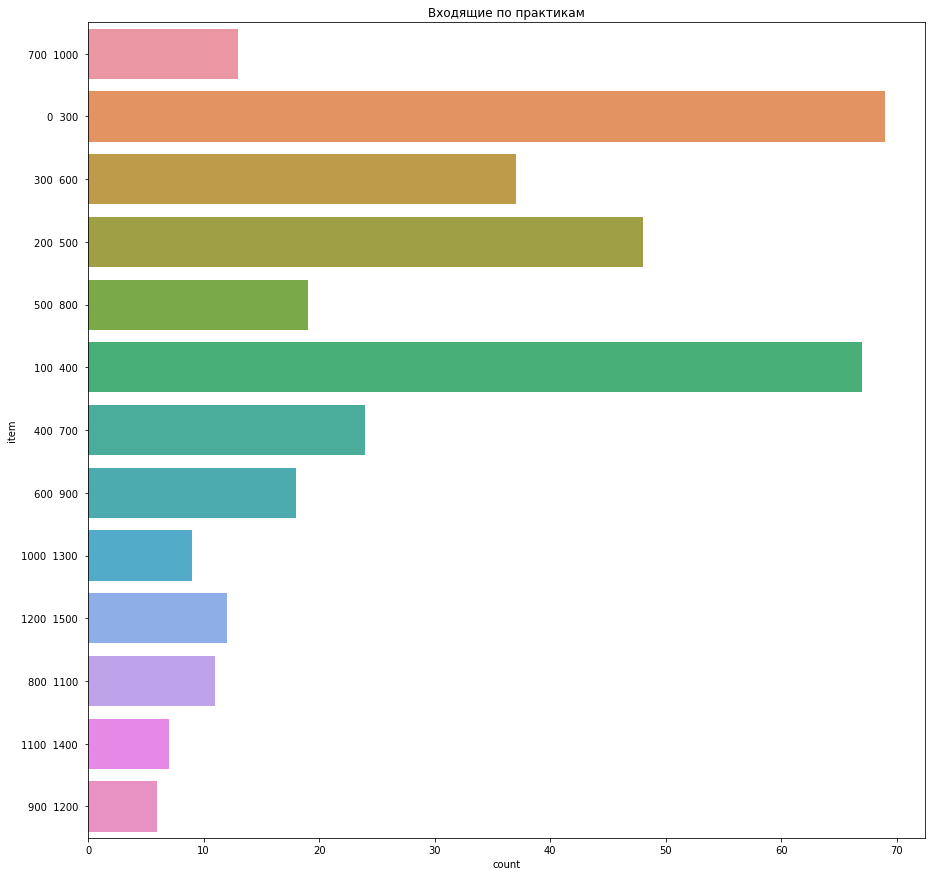

In [11]:
# for result in array_of_predicate_results:
plt.figure(figsize=(15, 15))
sns.countplot(y="item", data=pd.DataFrame(array_of_max_value2))
plt.title("Входящие по практикам")

In [12]:
array_of_predicate_results

[{'item': '0 and 300 and О согласовании основных условий договора поставки.docx',
  'count': 0.0024785534},
 {'item': '100 and 400 and О согласовании основных условий договора поставки.docx',
  'count': 0.003714681},
 {'item': '200 and 500 and О согласовании основных условий договора поставки.docx',
  'count': 0.02693112},
 {'item': '300 and 600 and О согласовании основных условий договора поставки.docx',
  'count': 0.0023156942},
 {'item': '400 and 700 and О согласовании основных условий договора поставки.docx',
  'count': 0.005028253},
 {'item': '500 and 800 and О согласовании основных условий договора поставки.docx',
  'count': 0.0047488715},
 {'item': '600 and 900 and О согласовании основных условий договора поставки.docx',
  'count': 0.01021092}]